# Getting Started

Here we go through a simplified rocket trajectory simulation to get you started. Let's start by importing the rocketpy module.

In [1]:
from rocketpy import Environment, SolidMotor, Rocket, Flight

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.

In [2]:
%matplotlib notebook

In [3]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

## Setting Up a Simulation

### Creating an Environment for Spaceport America

In [4]:
Env = Environment(
    railLength=5.0,
    latitude=-23.363611,
    longitude=-48.011389,
    elevation=660
) 

To get weather data from the GFS forecast, available online, we run the following lines.

First, we set tomorrow's date.

In [5]:
import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

Env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12)) # Hour given in UTC time

Then, we tell Env to use a GFS forecast to get the atmospheric conditions for flight.

Don't mind the warning, it just means that not all variables, such as wind speed or atmospheric temperature, are available at all altitudes given by the forecast.

In [6]:
Env.setAtmosphericModel(type='Forecast', file='GFS')

We can see what the weather will look like by calling the info method!

Launch Site Details

Launch Rail Length:  5.0  m
Launch Date:  2020-08-16 12:00:00  UTC
Launch Site Latitude: -23.36361°
Launch Site Longitude: -48.01139°
Launch Site Surface Elevation: 626.6 m


Atmospheric Model Details

Atmospheric Model Type:  Forecast
Forecast Maximum Height: 55.089 km
Forecast Time Period: From  2020-08-15 06:00:00  to  2020-08-25 06:00:00  UTC
Forecast Hour Interval:  3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 4.42 m/s
Surface Wind Direction: 164.43°
Surface Wind Heading: 344.43°
Surface Pressure: 943.20 hPa
Surface Temperature: 292.94 K
Surface Air Density: 1.122 kg/m³
Surface Speed of Sound: 343.11 m/s


Atmospheric Model Plots


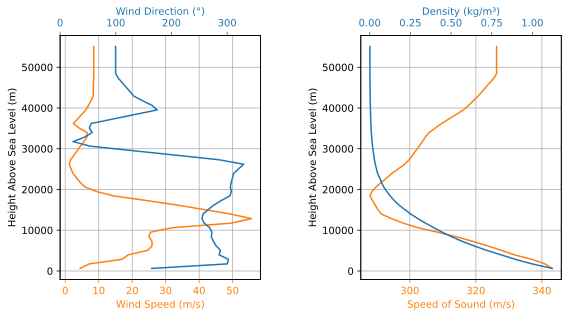

In [7]:
Env.info()

In [71]:
### Creating a Motor
#
#A solid rocket motor is used in this case. To create a motor, the SolidMotor class is used and the required #arguments are given.
#
#The SolidMotor class requires the user to have a thrust curve ready. This can come either from a .eng file for a #commercial motor, such as below, or a .csv file from a static test measurement.
#
#Besides the thrust curve, other parameters such as grain properties and nozzle dimensions must also be given.

SyntaxError: invalid syntax (<ipython-input-71-76cee42bb0c0>, line 3)

In [8]:
Mandioca = SolidMotor(
    thrustSource="data/mandioca/thrustCurve.csv",
    burnOut=3.51,
    grainNumber=5,
    grainSeparation=10/1000,
    grainDensity=1700,
    grainOuterRadius=47/1000,
    grainInitialInnerRadius=16/1000,
    grainInitialHeight=156/1000,
    nozzleRadius=33.5/1000,
    throatRadius=11.4/1000,
    interpolationMethod='linear'
)

To see what our thrust curve looks like, along with other import properties, we invoke the info method yet again. You may try the allInfo method if you want more information all at once!


Motor Details
Total Burning Time: 3.51 s
Total Propellant Mass: 8.136 kg
Propellant Exhaust Velocity: 1136.835 m/s
Average Thrust: 2635.032 N
Maximum Thrust: 2606.033374 N at 3.258 s after ignition.
Total Impulse: 9248.963 Ns

Plots


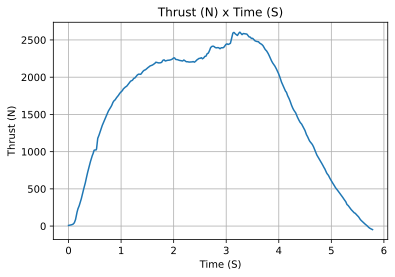

In [9]:
Mandioca.info()

### Creating a Rocket

A rocket is composed of several components. Namely, we must have a motor (good thing we have the Pro75M1670 ready), a couple of aerodynamic surfaces (nose cone, fins and tail) and parachutes (if we are not launching a missile).

Let's start by initializing our rocket, named Calisto, supplying it with the Pro75M1670 engine, entering its inertia properties, some dimensions and also its drag curves.

In [10]:
Panda = Rocket(
    motor=Mandioca,
    radius=127/2000,
    mass=15.538,
    inertiaI=6.995,
    inertiaZ=0.036,
    distanceRocketNozzle=1.86073 - (2964.29 /1000),
    distanceRocketPropellant=1.86073 - (2696.70 /1000),
    powerOffDrag='data/calisto/powerOffDragCurve.csv',
    powerOnDrag='data/calisto/powerOnDragCurve.csv'
)

Panda.setRailButtons([(1.86073-2.165), (1.86073- 2.768)], 60)

#### Adding Aerodynamic Surfaces

Now we define the aerodynamic surfaces. They are really straight forward.

In [11]:
NoseCone = Panda.addNose(length=0.560, kind="vonKarman", distanceToCM= (1.86073-0.560))

FinSet = Panda.addFins(3, span = 0.134, rootChord = 0.130, tipChord = 0.040, distanceToCM=(1.86073- (2790 /1000)))

Tail = Panda.addTail(topRadius=0.064, bottomRadius=0.0461, length=0.060, distanceToCM=(1.86073- (3024.29 /1000)))

#### Adding Parachutes

Finally, we have parachutes! Calisto will have two parachutes, Drogue and Main.

Both parachutes are activated by some special algorithm, which is usually really complex and a trade secret. Most algorithms are based on pressure sampling only, while some also use acceleration info.

RocketPy allows you to define a trigger function which will decide when to activate the ejection event for each parachute. This trigger function is supplied with pressure measurement at a predefined sampling rate. This pressure signal is usually noisy, so artificial noise parameters can be given. Call help(Rocket.addParachute) for more details. Furthermore, the trigger function also recieves the complete state vector of the rocket, allowing us to use velocity, acceleration or even attitude to decide when the parachute event should be triggered.

Here, we define our trigger functions rather simply using Python. However, you can call the exact code which will fly inside your rocket as well.

In [12]:
def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False

def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 m.
    return True if y[5] < 0 and y[2] < 800 else False

Main = Panda.addParachute('Main',
                            CdS=3.0127*0.9,
                            trigger=mainTrigger, 
                            samplingRate=105,
                            lag=1.0,
                            noise=(0, 8.3, 0.5))

Drogue = Panda.addParachute('Drogue',
                              CdS=1.001*0.75*1.1,
                              trigger=drogueTrigger, 
                              samplingRate=105,
                              lag=1.0,
                              noise=(0, 8.3, 0.5))

Just be careful if you run this last cell multiple times! If you do so, your rocket will end up with lots of parachutes which activate together, which may cause problems during the flight simulation. We advise you to re-run all cells which define our rocket before running this, preventing unwanted old parachutes. Alternatively, you can run the following lines to remove parachutes.

```python
Calisto.parachutes.remove(Drogue)
Calisto.parachutes.remove(Main)
```

## Simulating a Flight

Simulating a flight trajectory is as simples as initializing a Flight class object givin the rocket and environement set up above as inputs. The launch rail inclination and heading are also given here.

In [15]:
TestFlight = Flight(rocket=Panda, environment=Env, inclination=85, heading=0)

## Analysing the Results

RocketPy gives you many plots, thats for sure! They are divided into sections to keep them organized. Alternatively, see the Flight class documentation to see how to get plots for specific variables only, instead of all of them at once.

Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 626.63 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Launch Rail Orientation

Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Surface Wind Conditions

Frontal Surface Wind Speed: 4.26 m/s
Lateral Surface Wind Speed: 1.17 m/s


 Rail Departure State

Rail Departure Time: 0.799 s
Rail Departure Velocity: 19.881 m/s
Rail Departure Static Margin: -0.351 c
Rail Departure Angle of Attack: 12.781°
Rail Departure Thrust-Weight Ratio: 7.022
Rail Departure Reynolds Number: 1.572e+05


BurnOut State

BurnOut time: 3.510 s
Altitude at burnOut: 373.885 m (AGL)
Rocket velocity at burnOut: 279.601 m/s
Freestream velocity at burnOut: 279.016 m/s
Mach Number at burnOut: 0.815
Kinetic energy at burnOut: 6.971e+05 J


Apogee

A

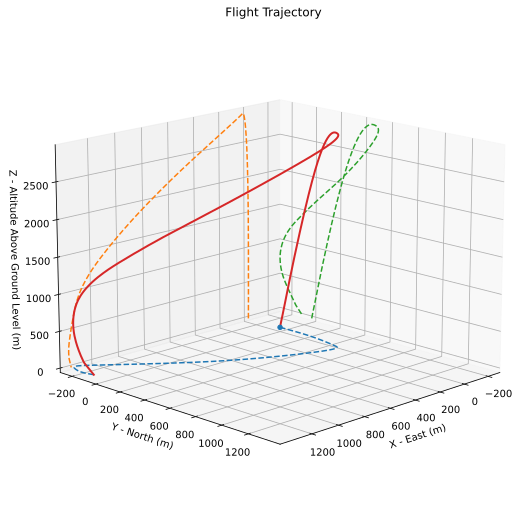



Trajectory Kinematic Plots



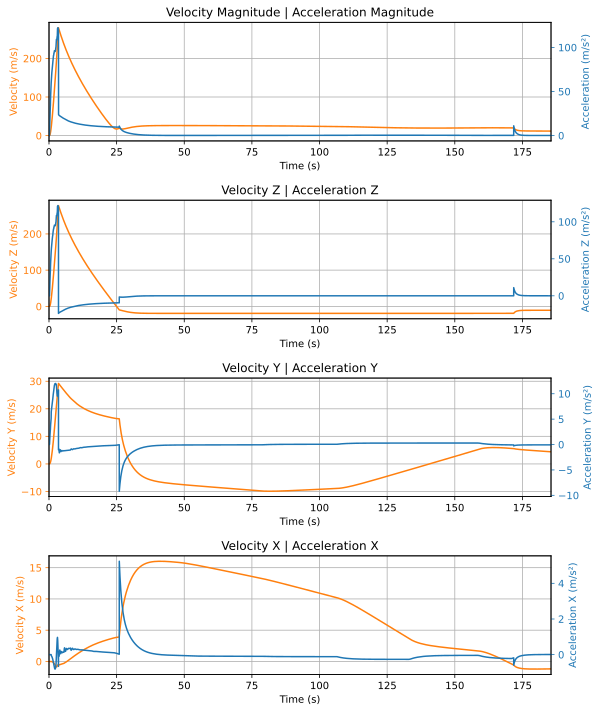



Angular Position Plots



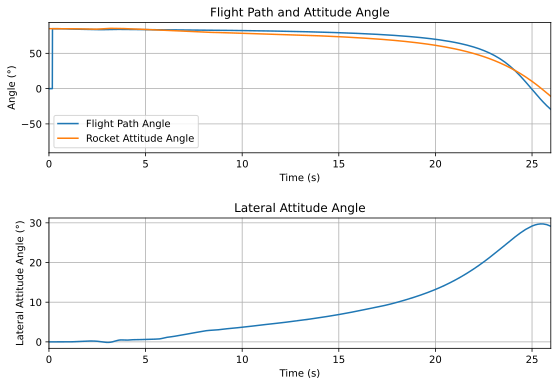



Path, Attitude and Lateral Attitude Angle plots



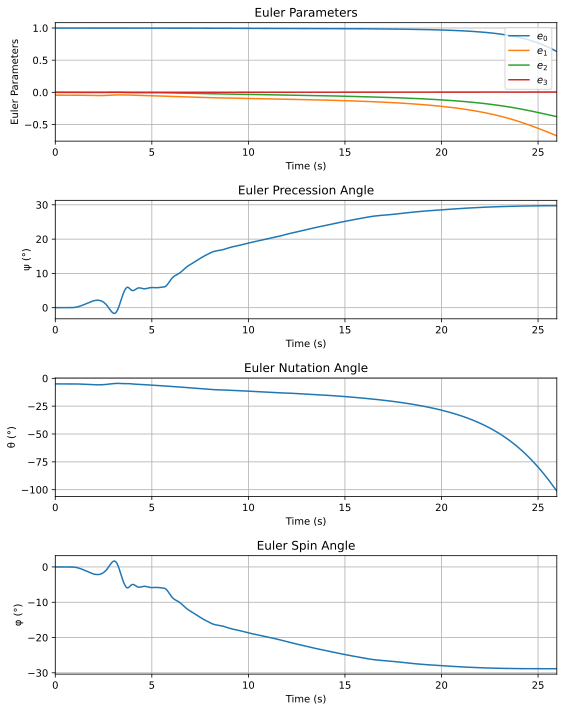



Trajectory Angular Velocity and Acceleration Plots



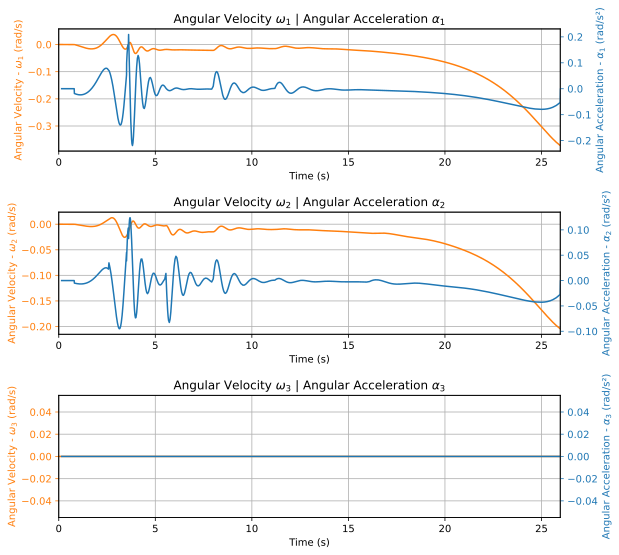



Trajectory Force Plots



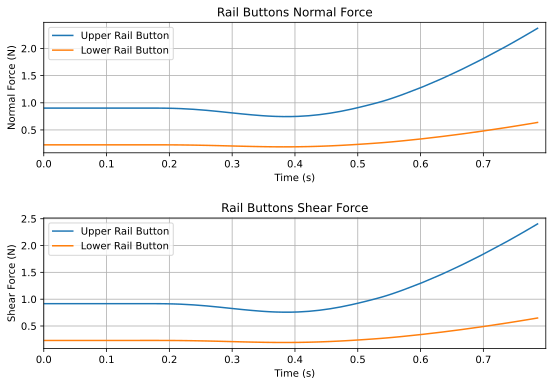

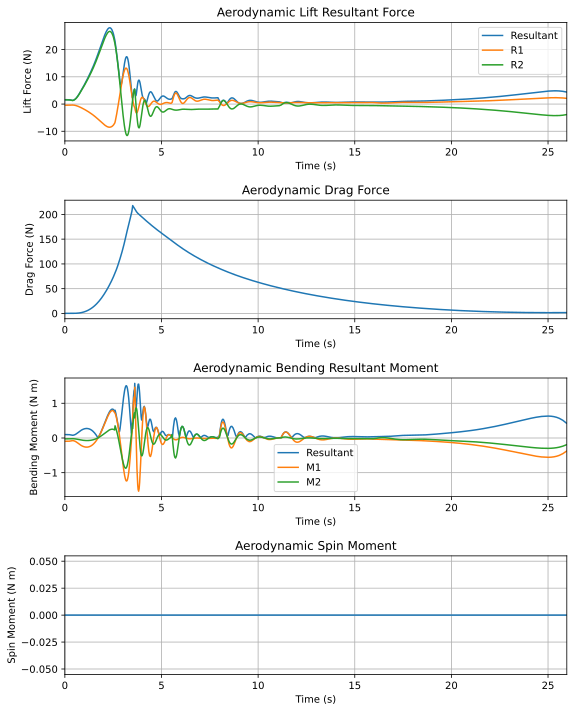



Trajectory Energy Plots



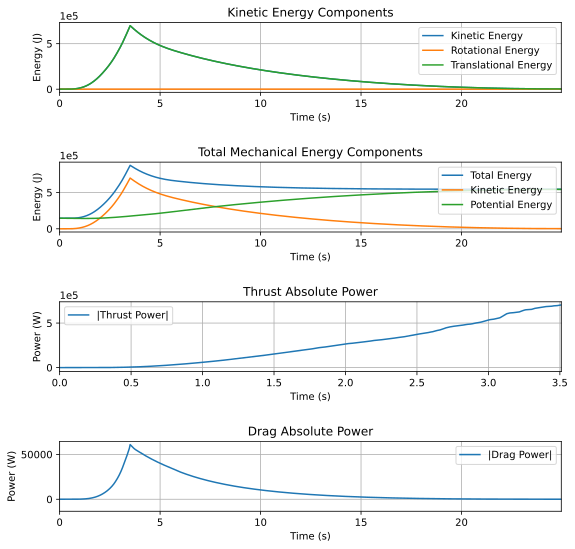



Trajectory Fluid Mechanics Plots



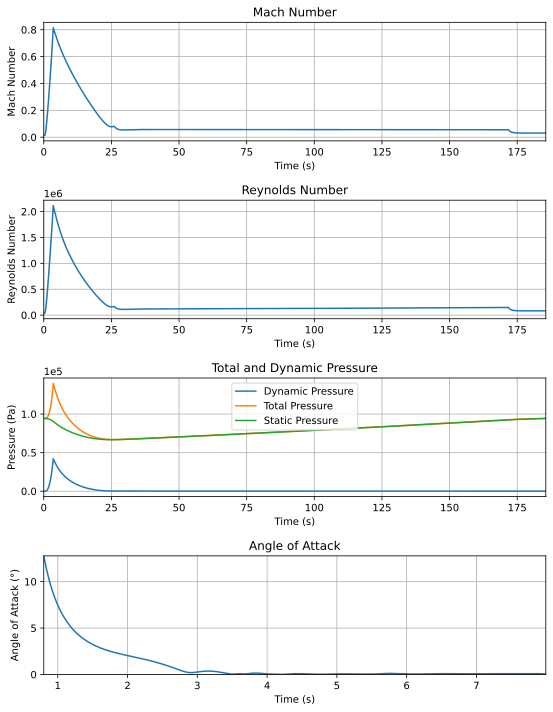



Trajectory Stability and Control Plots



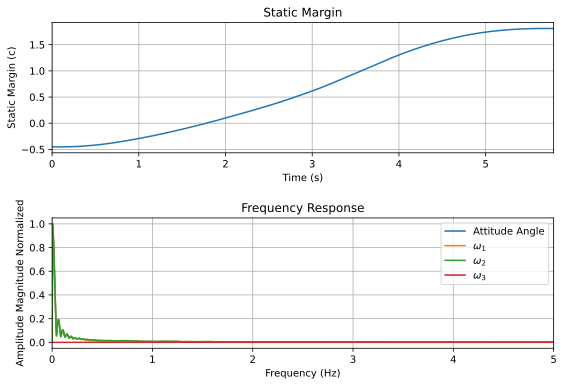

In [16]:
TestFlight.allInfo()

## Using Simulation for Design

Here, we go through a couple of examples which make use of RockePy in cool ways to help us design our rocket.

### Dynamic Stability Analysis

Ever wondered how static stability translates into dynamic stability? Different static margins result in different dynamic behaviour, which also depends on the rocket's rotational inertial.

Let's make use of RocketPy's helper class called Function to explore how the dynamic stability of Calisto varies if we change the fins span by a certain factor.

Simulating Rocket with Static Margin of -3.579->-2.164 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of -2.328->-0.914 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of -1.078->0.337 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 0.173->1.587 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 1.423->2.838 c
Simulation Completed at Time: 5.0000 s


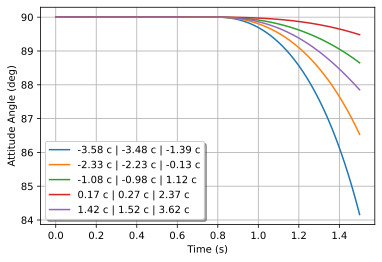

In [30]:
# Helper class
from rocketpy import Function

# Prepare Rocket Class
Panda = Rocket(motor=Mandioca,
                     radius=127/2000,
                     mass=15.538,
                     inertiaI=6.995,
                     inertiaZ=0.036,
                     distanceRocketNozzle=1.86073 - (2964.29 /1000),
                     distanceRocketPropellant=1.86073 - (2696.70 /1000),
                     powerOffDrag='data/calisto/powerOffDragCurve.csv',
                     powerOnDrag='data/calisto/powerOnDragCurve.csv')
Panda.setRailButtons([(1.86073-2.165), (1.86073- 2.768)], 60)
Nose = Panda.addNose(length=0.560, kind="vonKarman", distanceToCM= (1.86073-0.560))
FinSet = Panda.addFins(3, span = 0.134, rootChord = 0.130, tipChord = 0.040, distanceToCM=(1.86073- (2790 /1000)))
Tail = Panda.addTail(topRadius=0.064, bottomRadius=0.0461, length=0.060, distanceToCM=(1.86073- (3024.29 /1000)))

# Prepare Environment Class
Env = Environment(5.0, 9.8)
Env.setAtmosphericModel(type='CostumAtmosphere', wind_v=-5)

# Simulate Different Static Margins by Varying Fin Position
simulation_results = []

for factor in [0.5, 0.7, 0.9, 1.1, 1.3]:
    # Modify rocket fin set by removing previous one and adding new one
    Panda.aerodynamicSurfaces.remove(FinSet)
    FinSet = Panda.addFins(3, span = 0.134, rootChord = 0.130, tipChord = 0.040, distanceToCM=(1.86073- (2790 /1000))*factor))
    # Simulate
    print('Simulating Rocket with Static Margin of {:1.3f}->{:1.3f} c'.format(Panda.staticMargin(0), Panda.staticMargin(Panda.motor.burnOutTime)))
    TestFlight = Flight(rocket=Panda, environment=Env, inclination=90, heading=0, maxTimeStep=0.01, maxTime=5, terminateOnApogee=True, verbose=True)
    # Post process flight data
    TestFlight.postProcess()
    # Store Results
    staticMarginAtIginition = Panda.staticMargin(0)
    staticMarginAtOutOfRail = Panda.staticMargin(TestFlight.outOfRailTime)
    staticMarginAtSteadyState = Panda.staticMargin(TestFlight.tFinal)
    simulation_results += [(TestFlight.attitudeAngle, '{:1.2f} c | {:1.2f} c | {:1.2f} c'.format(staticMarginAtIginition, staticMarginAtOutOfRail, staticMarginAtSteadyState))]

Function.comparePlots(simulation_results, lower=0, upper=1.5, xlabel='Time (s)', ylabel='Attitude Angle (deg)')

### Characteristic Frequency Calculation

Here we analyse the characterist frequency of oscilation of our rocket just as it leaves the launch rail. Note that when we ran TestFlight.allInfo(), one of the plots already showed us the frequency spectrum of our flight. Here, however, we have more control of what we are plotting.

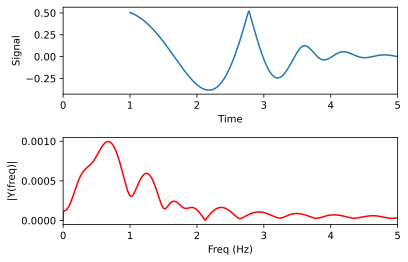

In [31]:
import numpy as np
import matplotlib.pyplot as plt

Env = Environment(
    railLength=5.0,
    latitude=-23.363611,
    longitude=-48.011389,
    elevation=660
) 

Env.setAtmosphericModel(type='CostumAtmosphere', wind_v=-5)

# Prepare Motor
Mandioca = SolidMotor(
    thrustSource="data/mandioca/thrustCurve.csv",
    burnOut=3.51,
    grainNumber=5,
    grainSeparation=10/1000,
    grainDensity=1700,
    grainOuterRadius=47/1000,
    grainInitialInnerRadius=16/1000,
    grainInitialHeight=156/1000,
    nozzleRadius=33.5/1000,
    throatRadius=11.4/1000,
    interpolationMethod='linear'
)

# Prepare Rocket
Panda = Rocket(
    motor=Mandioca,
    radius=127/2000,
    mass=15.538,
    inertiaI=6.995,
    inertiaZ=0.036,
    distanceRocketNozzle=1.86073 - (2964.29 /1000),
    distanceRocketPropellant=1.86073 - (2696.70 /1000),
    powerOffDrag='data/calisto/powerOffDragCurve.csv',
    powerOnDrag='data/calisto/powerOnDragCurve.csv')

Panda.setRailButtons([(1.86073-2.165), (1.86073- 2.768)], 60)

Nose = Panda.addNose(length=0.560, kind="vonKarman", distanceToCM= (1.86073-0.560))
FinSet = Panda.addFins(3, span = 0.134, rootChord = 0.130, tipChord = 0.040, distanceToCM=(1.86073- (2790 /1000)))
Tail = Panda.addTail(topRadius=0.064, bottomRadius=0.0461, length=0.060, distanceToCM=(1.86073- (3024.29 /1000)))
# Simulate first 5 seconds of Flight
TestFlight = Flight(rocket=Panda, environment=Env, inclination=90, heading=0, maxTimeStep=0.01, maxTime=5)
TestFlight.postProcess()

# Perform a Fourier Analysis
Fs = 100.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(1,400,Ts) # time vector
ff = 5;   # frequency of the signal
y = TestFlight.attitudeAngle(t) - np.mean(TestFlight.attitudeAngle(t))
n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n//2)] # one side frequency range
Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(n//2)]
fig, ax = plt.subplots(2, 1)
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Signal')
ax[0].set_xlim((0, 5))
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')
ax[1].set_xlim((0, 5))
plt.subplots_adjust(hspace=0.5)
plt.show()

### Apogee as a Function of Mass

This one is a classic one! We always need to know how much our rocket's apogee will change when our payload gets havier.

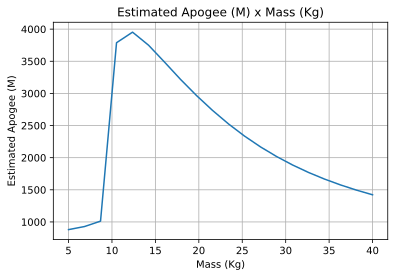

In [40]:
def apogee(mass):
    # Prepare Environment
    Env = Environment(
    railLength=5.0,
    latitude=-23.363611,
    longitude=-48.011389,
    elevation=660
  ) 
    
    Env.setAtmosphericModel(type='CostumAtmosphere', wind_v=-5)

    # Prepare Motor
    Mandioca = SolidMotor(
        thrustSource="data/mandioca/thrustCurve.csv",
        burnOut=3.51,
        grainNumber=5,
        grainSeparation=10/1000,
        grainDensity=1700,
        grainOuterRadius=47/1000,
        grainInitialInnerRadius=16/1000,
        grainInitialHeight=156/1000,
        nozzleRadius=33.5/1000,
        throatRadius=11.4/1000,
        interpolationMethod='linear'
    )

    # Prepare Rocket
    Panda = Rocket(
        motor=Mandioca,
        radius=127/2000,
        mass=mass,
        inertiaI=6.995,
        inertiaZ=0.036,
        distanceRocketNozzle=1.86073 - (2964.29 /1000),
        distanceRocketPropellant=1.86073 - (2696.70 /1000),
        powerOffDrag='data/calisto/powerOffDragCurve.csv',
        powerOnDrag='data/calisto/powerOnDragCurve.csv'
    )
    
    Panda.setRailButtons([(1.86073-2.165), (1.86073- 2.768)],)

    Nose = Panda.addNose(length=0.560, kind="vonKarman", distanceToCM= (1.86073-0.560))
    FinSet = Panda.addFins(3, span = 0.134, rootChord = 0.130, tipChord = 0.040, distanceToCM=(1.86073- (2790 /1000)))
    Tail = Panda.addTail(topRadius=0.064, bottomRadius=0.0461, length=0.060, distanceToCM=(1.86073- (3024.29 /1000)))

    # Simulate Flight until Apogee
    TestFlight = Flight(rocket=Panda, environment=Env, inclination=85, heading=0, terminateOnApogee=True)
    return TestFlight.apogee

apogeebymass = Function(apogee, inputs="Mass (kg)", outputs="Estimated Apogee (m)")
apogeebymass.plot(5,40,20)

### Out of Rail Speed as a Function of Mass

To finish off, lets make a really important plot. Out of rail speed is the speed our rocket has when it is leaving the launch rail. This is crucial to make sure it can fly safely after leaving the rail. A common rule of thumb is that our rocket's out of rail speed should be 4 times the wind speed so that it does not stall and become unstable.

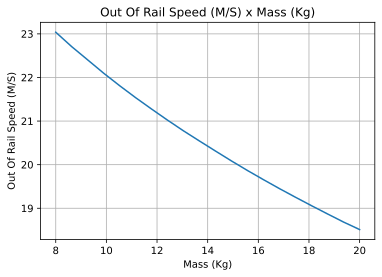

In [41]:
def speed(mass):
    # Prepare Environment
    Env = Environment(
        railLength=5.0,
        latitude=-23.363611,
        longitude=-48.011389,
        elevation=660
    )
    
    Env.setAtmosphericModel(type='CostumAtmosphere', wind_v=-5)

    # Prepare Motor
    Mandioca = SolidMotor(
        thrustSource="data/mandioca/thrustCurve.csv",
        burnOut=3.51,
        grainNumber=5,
        grainSeparation=10/1000,
        grainDensity=1700,
        grainOuterRadius=47/1000,
        grainInitialInnerRadius=16/1000,
        grainInitialHeight=156/1000,
        nozzleRadius=33.5/1000,
        throatRadius=11.4/1000,
        interpolationMethod='linear'
    )

    # Prepare Rocket
    Panda = Rocket(motor=Mandioca,
                    radius=127/2000,
                    mass=mass,
                    inertiaI=6.995,
                    inertiaZ=0.036,
                    distanceRocketNozzle=1.86073 - (2964.29 /1000),
                    distanceRocketPropellant=1.86073 - (2696.70 /1000),
                    powerOffDrag='data/calisto/powerOffDragCurve.csv',
                    powerOnDrag='data/calisto/powerOnDragCurve.csv')
    Panda.setRailButtons([(1.86073-2.165), (1.86073- 2.768)])
    Nose = Panda.addNose(length=0.560, kind="vonKarman", distanceToCM= (1.86073-0.560))
    FinSet = Panda.addFins(3, span = 0.134, rootChord = 0.130, tipChord = 0.040, distanceToCM=(1.86073- (2790 /1000)))
    Tail = Panda.addTail(topRadius=0.064, bottomRadius=0.0461, length=0.060, distanceToCM=(1.86073- (3024.29 /1000)))

    # Simulate Flight until Apogee
    TestFlight = Flight(rocket=Panda, environment=Env, inclination=85, heading=0, terminateOnApogee=True)
    return TestFlight.outOfRailVelocity

speedbymass = Function(speed, inputs="Mass (kg)", outputs="Out of Rail Speed (m/s)")
speedbymass.plot(8,20,20)